In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [2]:
class CFG:    
    # config
    WORK_DIR = '../input/cassava-leaf-disease-classification'
    BATCH_SIZE = 8
    EPOCHS = 5
    TARGET_SIZE = 256
    NCLASSES = 5

# Functions

In [3]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (CFG.TARGET_SIZE, CFG.TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(CFG.NCLASSES, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

# Data

In [4]:
train_labels = pd.read_csv(os.path.join(CFG.WORK_DIR, "train.csv"))

STEPS_PER_EPOCH = len(train_labels)*0.8 / CFG.BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / CFG.BATCH_SIZE
    
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


### ImageDataGenerator

In [5]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2, preprocessing_function = None,
                                     rotation_range = 45, zoom_range = 0.2,
                                     horizontal_flip = True, vertical_flip = True,
                                     fill_mode = 'nearest', shear_range = 0.1,
                                     height_shift_range = 0.1, width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels, directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "training", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(CFG.WORK_DIR, "train_images"),
                         subset = "validation", x_col = "image_id",
                         y_col = "label", target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE),
                         batch_size = CFG.BATCH_SIZE, class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


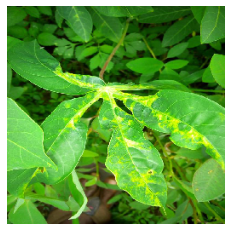

In [6]:
img_path = os.path.join(CFG.WORK_DIR, "train_images", train_labels.image_id[20])
img = image.load_img(img_path, target_size = (CFG.TARGET_SIZE, CFG.TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

# Modeling

In [7]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [8]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


### Training

In [9]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = CFG.EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/5
2140/2139 [==============================] - ETA: 0s - loss: 1.1375 - acc: 0.6118
Epoch 00001: val_loss improved from inf to 1.06812, saving model to ./EffNetB0_512_8_best_weights.h5
2140/2139 [==============================] - 538s 251ms/step - loss: 1.1375 - acc: 0.6118 - val_loss: 1.0681 - val_acc: 0.6109
Epoch 2/5
2140/2139 [==============================] - ETA: 0s - loss: 1.0242 - acc: 0.6269
Epoch 00002: val_loss improved from 1.06812 to 1.01358, saving model to ./EffNetB0_512_8_best_weights.h5
2140/2139 [==============================] - 448s 209ms/step - loss: 1.0242 - acc: 0.6269 - val_loss: 1.0136 - val_acc: 0.6305
Epoch 3/5
2140/2139 [==============================] - ETA: 0s - loss: 0.9708 - acc: 0.6409
Epoch 00003: val_loss improved from 1.01358 to 0.89185, saving model to ./EffNetB0_512_8_best_weights.h5
2140/2139 [==============================] - 451s 211ms/step - loss: 0.9708 - acc: 0.6409 - val_loss: 0.8918 - val_acc: 0.6649
Epoch 4/5
2140/2139 [===========

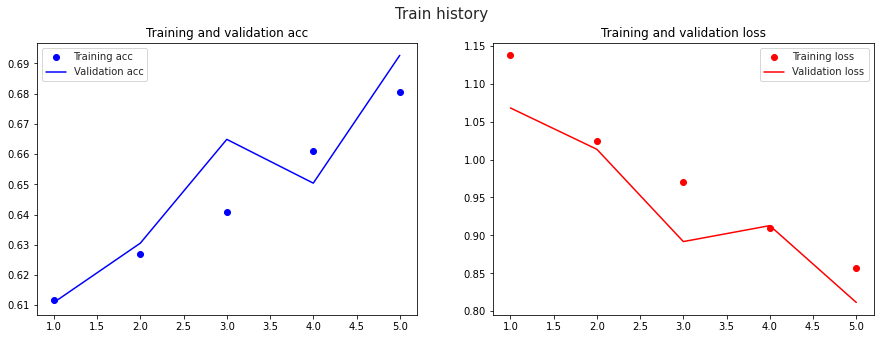

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [12]:
model.save('./EffNetB0_512_8.h5')

# Prediction

In [13]:
submit_df = pd.read_csv(os.path.join(CFG.WORK_DIR, "sample_submission.csv"))

preds = []

for image_id in submit_df.image_id:
    image = Image.open(os.path.join(CFG.WORK_DIR,  "test_images", image_id))
    image = image.resize((CFG.TARGET_SIZE, CFG.TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

submit_df['label'] = preds
submit_df.to_csv('submission.csv', index = False)